<a href="https://colab.research.google.com/github/Sebanthalas/fem-dnn/blob/main/Tester_NSEBrikman_UQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
%cd drive/MyDrive/project_dnn
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time
import os, sys, shutil
from google.colab import files
#!python -m pip install Tasmanian --user
!pip install hdf5storage


/content/drive/MyDrive/project_dnn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
%cd drive/MyDrive/project_dnn
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers, regularizers
# Other libraries
import scipy.io as sio
from fenics import *
#import Tasmanian
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as la
import time, os, argparse, io, shutil, sys, math, socket
import scipy.io as sio
from dolfin import *
import sympy2fenics as sf
import random
import os
!pwd

/content/drive/MyDrive/project_dnn
/content/drive/MyDrive/project_dnn


In [14]:

parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 4
parameters["allow_extrapolation"]= True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"


fileO = XDMFFile("outputs/complexChannelFlow-AFW.xdmf")
fileO.parameters["functions_share_mesh"] = True
fileO.parameters["flush_output"] = True

# ****** Constant coefficients ****** #

f  = Constant((0,1))
ndim = 2
Id = Identity(ndim)

lam = Constant(0.1)
# *********** Variable coefficients ********** #

uinlet = Expression(('0','x[0]*(1.-x[0])'), degree = 2)
eta = Expression('0.1 + 0.01*sin(x[0])*sin(x[1])', degree=3)
#eta = Expression('0.1+x[0]*x[0]+x[1]*x[1]', degree=2)
mu = Expression('exp(-x[0]*x[1])', degree = 3)


l = 1 
meshname="meshes/complex_channel/ComplexChannel.xml"

mesh = Mesh(meshname)
bdry = MeshFunction("size_t", mesh, "meshes/complex_channel/ComplexChannel_facet_region.xml")
wall = 30; inlet=10; outlet=20;
nn   = FacetNormal(mesh)
tan  = as_vector((-nn[1],nn[0])) # DIMMMMMM
    
ds = Measure("ds", subdomain_data = bdry)
dx = Measure("dx", domain=mesh)
dS = Measure("dS", subdomain_data=bdry)

Ht = VectorElement('DG', mesh.ufl_cell(), l+1, dim = 3)
Hsig = FiniteElement('BDM', mesh.ufl_cell(), l+1)# In FEniCS, Hdiv tensors need to be defined row-wise
Hu = VectorElement('DG', mesh.ufl_cell(), l)
Hgam = FiniteElement('DG', mesh.ufl_cell(), l)    

Hh = FunctionSpace(mesh, MixedElement([Ht,Hsig,Hsig,Hu,Hgam]))

# spaces to project for visualisation only
Ph = FunctionSpace(mesh,'CG',1)
Th = TensorFunctionSpace(mesh,'CG',1)
    
print (" ****** Total DoF = ", Hh.dim())
    
# *********** Trial and test functions ********** #
Trial = TrialFunction(Hh)
Sol   = Function(Hh) 
t_, sig1, sig2,u,gam_ = split(Sol)
s_, tau1, tau2,v,del_ = TestFunctions(Hh)

t = as_tensor(((t_[0], t_[1]),(t_[2],-t_[0])))
s = as_tensor(((s_[0], s_[1]),(s_[2],-s_[0])))

sigma = as_tensor((sig1,sig2))
tau   = as_tensor((tau1,tau2))

gamma = as_tensor(((0,gam_),(-gam_,0)))
delta = as_tensor(((0,del_),(-del_,0)))

# ********** Boundary conditions ******** #

zero = Constant((0.,0.))
#bcsig1 = DirichletBC(Hh.sub(4), zero, bdry, wall)
#bcsig2 = DirichletBC(Hh.sub(5), zero, bdry, wall)
#bcD = [bcsig1,bcsig2]

nitsche = Constant(1.e4)
    
# *************** Variational forms ***************** #
a   = lam*mu*inner(t,s)*dx 
b1  = - inner(sigma,s)*dx
b   = - inner(outer(u,u),s)*dx
b2  = inner(t,tau)*dx
bbt = dot(u,div(tau))*dx + inner(gamma,tau)*dx
bb  = dot(div(sigma),v)*dx + inner(sigma,delta)*dx
cc  = eta * dot(u,v)*dx

#+ xi*tr(tau+outer(v,v))*dx ???
AA = a + b1 + b2 + b + bbt + bb - cc 
FF = dot(tau*nn,uinlet)*ds(inlet) - dot(f,v)*dx
Nonl = AA - FF + nitsche * dot((sigma+outer(u,u))*nn,tau*nn)*ds(outlet)
#Nonl = AA - FF + nitsche * dot((sigma)*nn,tau*nn)*ds(outlet)

Tangent = derivative(Nonl, Sol, Trial)
Problem = NonlinearVariationalProblem(Nonl, Sol, J=Tangent)
Solver  = NonlinearVariationalSolver(Problem)
Solver.parameters['nonlinear_solver']                    = 'newton'
Solver.parameters['newton_solver']['linear_solver']      = 'mumps'
Solver.parameters['newton_solver']['absolute_tolerance'] = 1e-8
Solver.parameters['newton_solver']['relative_tolerance'] = 1e-8
Solver.parameters['newton_solver']['maximum_iterations'] = 25
    
Solver.solve()
th_, sigh1, sigh2,uh,gamh_ = Sol.split()
    
th = as_tensor(((th_[0], th_[1]),(th_[2],-th_[0])))
sigmah = as_tensor((sigh1,sigh2))
gammah = as_tensor(((0,gamh_),(-gamh_,0)))

ph = project(-1/ndim*tr(sigmah + outer(uh,uh)),Ph) 

sig_v = project(sigmah, Th)
t_v = project(th, Th) 
g_v = project(gammah, Th)  

 ****** Total DoF =  865392


In [ ]:




    



    


uh.rename("u","u"); fileO.write(uh,0)
t_v.rename("t","t"); fileO.write(t_v,0)
sig_v.rename("sig","sig"); fileO.write(sig_v,0)
ph.rename("p","p"); fileO.write(ph,0)
g_v.rename("gamma","gamma"); fileO.write(g_v,0)

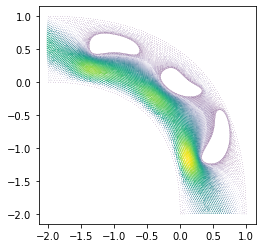

In [16]:
plot(uh)